In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PINNFlow import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import mean_squared_error
import time
import warnings
warnings.filterwarnings('ignore')

# Example: Westward Flow under the Atlantic

This is some example code to find the horizontal flow at the CMB in a region underneath the Atlantic. 

The following code snippet allows you to train on a GPU, if you have one, or else defaults to a CPU. GPU training is faster, but CPUs can still be used if this is not available.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading in data

For this example, we are wanting to study an area in the Atlantic, at spherical harmonic degree 13, on the 1st January 2024. 

To do this, we will use the CHAOS-8.1 model, but any Geomagnetic Field model can be used if it is in the same format. We then supply the path to the MAT-file, and then use the data_generator function to calculate the values on a grid. 

In [3]:
mat_file = "CHAOS-8.1.mat"

In [4]:
radius_data, phi_data, theta_data, Br_data, Br_dot_data, Br_div_theta_data , Br_div_phi_data = data_generator(mat_file, 2024, 1, 1, 13,  dy = 30 , dx = 55, clat1 = 55,clat2 = 85, long1 = -50, long2 = 5)

Text(784.8402777777776, 0.5, 'Latitude')

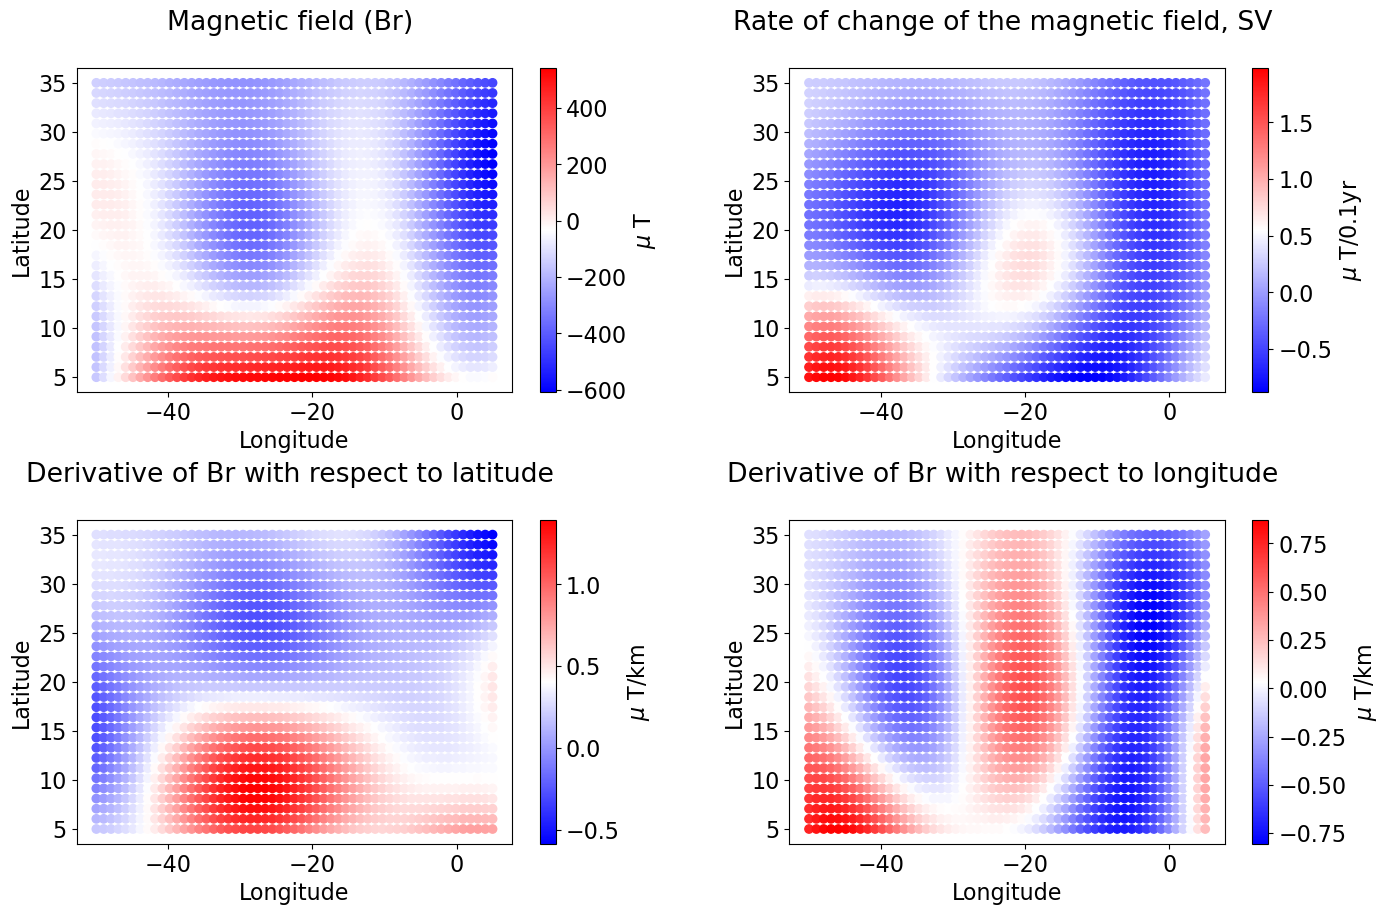

In [5]:
plt.rcParams.update({'font.size': 16})
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15,10))
plot1 = ax1.scatter(phi_data*180/np.pi, 90-theta_data*180/np.pi,c=Br_data,cmap = 'bwr')
plot2 = ax2.scatter(phi_data*180/np.pi, 90-theta_data*180/np.pi, c=Br_dot_data,cmap = 'bwr')
plt.colorbar(plot1, ax = ax1, label = '$\mu$ T')
plt.colorbar(plot2, ax = ax2, label = '$\mu$ T/0.1yr')
plt.tight_layout(pad=3)
ax1.set_title('Magnetic field (Br) \n')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax2.set_title('Rate of change of the magnetic field, SV \n')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plot3 = ax3.scatter(phi_data*180/np.pi, 90-theta_data*180/np.pi, c=Br_div_theta_data,cmap = 'bwr')
plot4 = ax4.scatter(phi_data*180/np.pi, 90-theta_data*180/np.pi, c=Br_div_phi_data,cmap = 'bwr')
plt.colorbar(plot3, ax = ax3, label = '$\mu$ T/km')
plt.colorbar(plot4, ax = ax4, label = '$\mu$ T/km')
plt.tight_layout(pad=3)
ax3.set_title('Derivative of Br with respect to latitude \n')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax4.set_title('Derivative of Br with respect to longitude \n')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

PyTorch requires that each of the input are flattened and in torch.Tensor format, so we do that:

In [6]:
theta = theta_data.flatten()[:,None]
phi = phi_data.flatten()[:,None]
radius = 3485*np.ones(theta.shape)
print("theta shape: ", theta.shape, ",phi shape: ", phi.shape)
print("sv shape: ", Br_dot_data.shape)
PHI,THETA = np.meshgrid(phi, theta)

coord =  np.hstack((phi.flatten()[:,None], theta.flatten()[:,None])) 
sv_star = Br_dot_data.flatten()[:, None]
br_star = Br_data.flatten()[:, None]
horiz_theta_star = Br_div_theta_data.flatten()[:, None]
horiz_phi_star = Br_div_phi_data.flatten()[:, None]
print("Coord shape: ", coord.shape)
print("SV_STAR shape: ", sv_star.shape)

theta shape:  (1650, 1) ,phi shape:  (1650, 1)
sv shape:  (30, 55)
Coord shape:  (1650, 2)
SV_STAR shape:  (1650, 1)


In [7]:
radius_tf = torch.tensor(radius, requires_grad=True).float()
theta_tf = torch.tensor(theta, requires_grad=True).float()
phi_tf = torch.tensor(phi, requires_grad=True).float()
br_tf = torch.tensor(br_star, requires_grad=True).float()
sv_tf = torch.tensor(sv_star, requires_grad=True).float()
horiz_theta_tf = torch.tensor(horiz_theta_star, requires_grad=True).float()
horiz_phi_tf = torch.tensor(horiz_phi_star, requires_grad=True).float()

## Defining Models

We define the blank model from the layers and the upper and lower bound for the coordinate system. The model weights are initialised using Xavier Initialisation. 

In [8]:
#Layers for NN, has to start and end with 2 for (theta, phi)
layers =[2,40, 40, 40, 40, 40, 40, 40, 40, 2]

In [9]:
lb = coord.min(0) #Lower Bound for coordinate system 
ub = coord.max(0) #Upper Bound for coordinate system 

In [10]:
model = NeuralNet(layers, lb, ub) #Defining NN model for T, P

## Training
We define the number of training iterations, and empty arrays to record the loss:

In [11]:
Train_iterations = 10_000 #can be changed, value used in paper is 100_000 to ensure convergence

loss_record = np.zeros(Train_iterations) #Total Loss
loss_data_record = np.zeros(Train_iterations) #SV Loss
loss_flows_record = np.zeros(Train_iterations) #Flow Constraint Loss

In [12]:
# Calling Training function
train(Train_iterations, "model_name", radius_tf, phi_tf, theta_tf, sv_tf, horiz_theta_tf, horiz_phi_tf,br_tf,  model, loss_data_record, loss_flows_record, loss_record)

It: 0, Total Loss: 3.536e+00, SV Loss: 3.527e+00, Flow Loss: 8.554e-03, Time: 0.12
It: 50, Total Loss: 5.194e-02, SV Loss: 5.152e-02, Flow Loss: 4.152e-04, Time: 4.66
Loss Improved, Saving Model
It: 100, Total Loss: 3.548e-02, SV Loss: 3.491e-02, Flow Loss: 5.743e-04, Time: 3.98
Loss Improved, Saving Model
It: 150, Total Loss: 2.617e-02, SV Loss: 2.528e-02, Flow Loss: 8.949e-04, Time: 4.42
Loss Improved, Saving Model
It: 200, Total Loss: 2.141e-02, SV Loss: 2.025e-02, Flow Loss: 1.151e-03, Time: 3.56
Loss Improved, Saving Model
It: 250, Total Loss: 1.694e-02, SV Loss: 1.556e-02, Flow Loss: 1.386e-03, Time: 4.46
Loss Improved, Saving Model
It: 300, Total Loss: 1.334e-02, SV Loss: 1.166e-02, Flow Loss: 1.671e-03, Time: 4.60
Loss Improved, Saving Model
It: 350, Total Loss: 1.185e-02, SV Loss: 1.023e-02, Flow Loss: 1.625e-03, Time: 5.01
Loss Improved, Saving Model
It: 400, Total Loss: 1.117e-02, SV Loss: 9.580e-03, Flow Loss: 1.586e-03, Time: 4.42
Loss Improved, Saving Model
It: 450, Total

We can then plot the loss curves using:

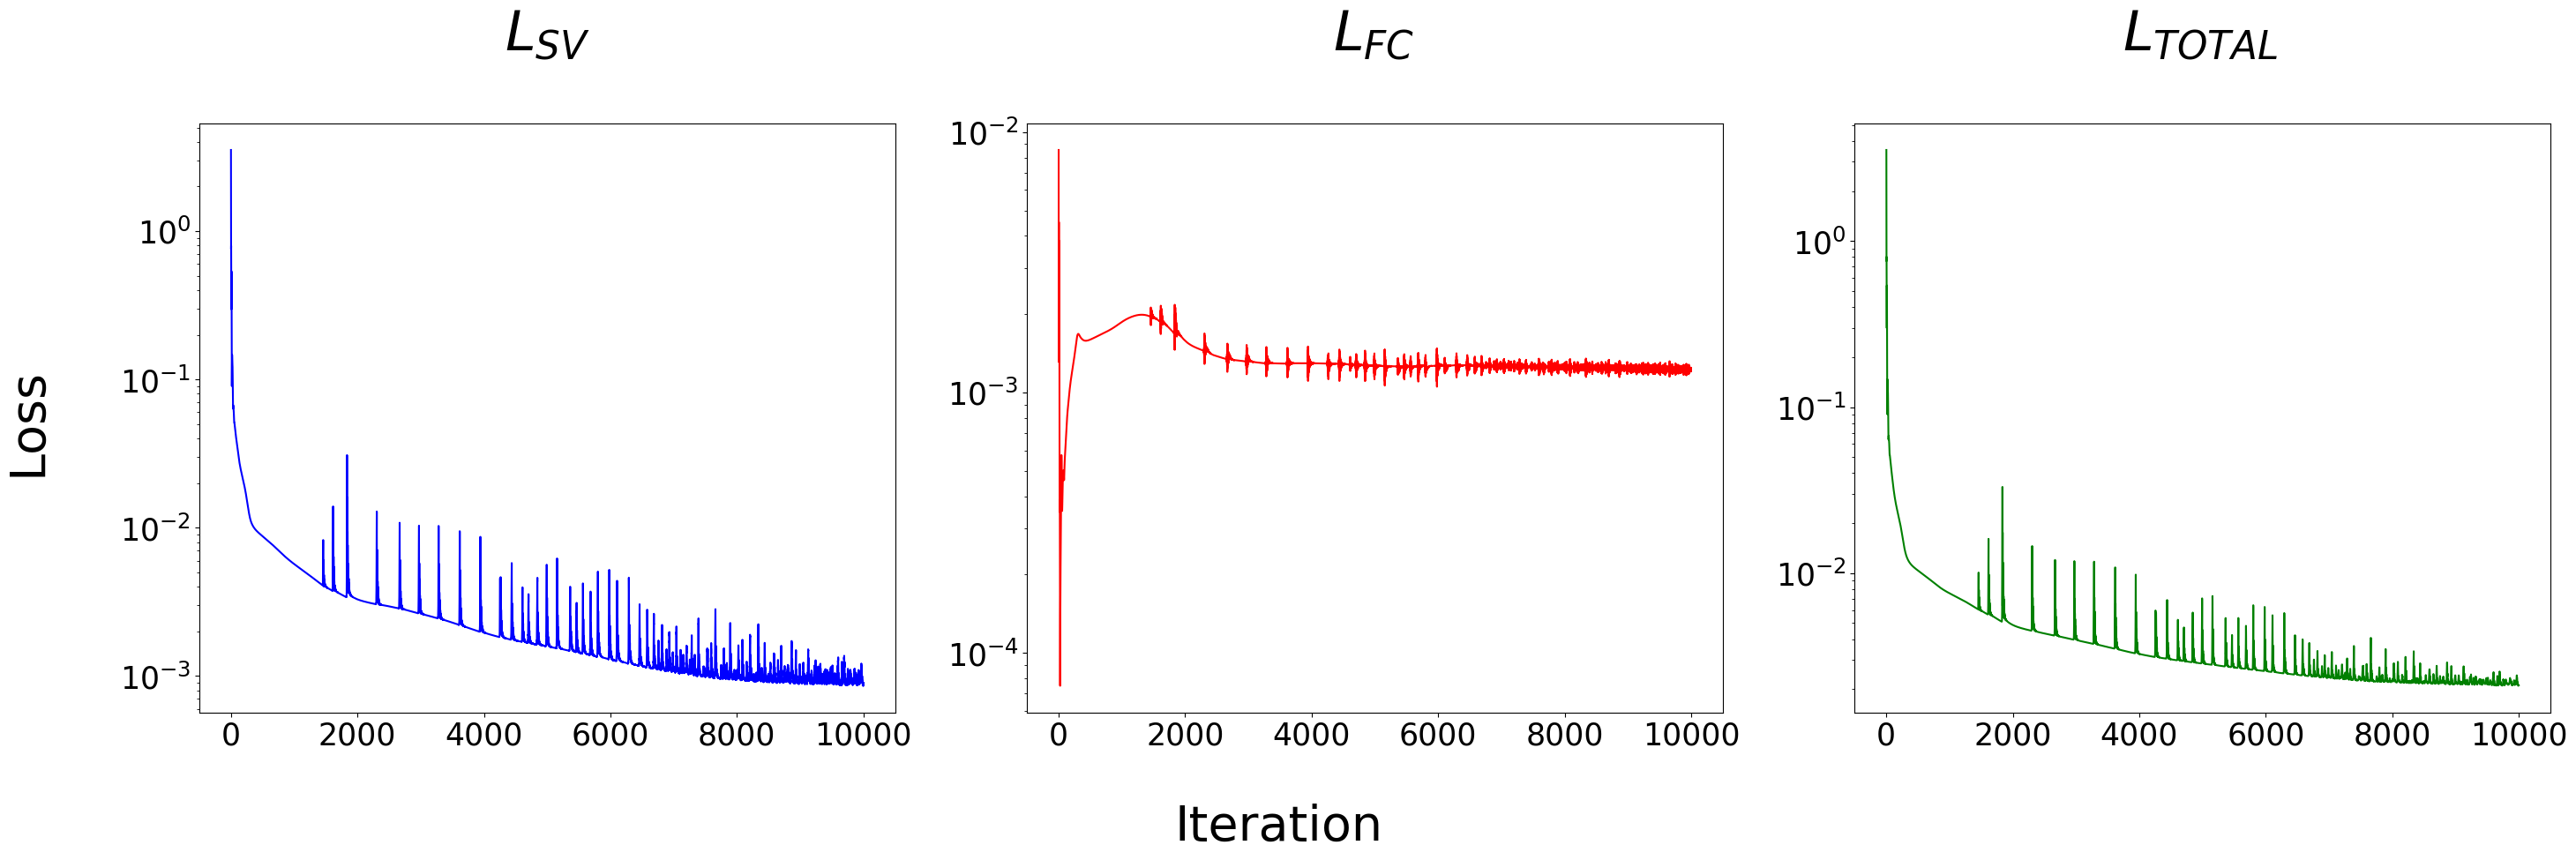

In [13]:
plt.rcParams.update({'font.size': 25})
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(30,10))
ax1.semilogy(loss_data_record, color = 'blue')
ax2.semilogy(loss_flows_record, color = 'red')
ax3.semilogy(loss_record, color = 'green')
ax1.set_title("$L_{SV}$ \n", size = 45)
ax2.set_title("$L_{FC}$ \n", size = 45)
ax3.set_title("$L_{TOTAL}$ \n", size = 45)

fig.supxlabel('Iteration', size = 40)
fig.supylabel('Loss \n', size = 40)
plt.tight_layout(pad=1)

## Results

Load in the model with the lowest loss, and then evaluate the trained model values on our grid:

In [14]:
model = torch.load("model_name.pt", weights_only=False) #Loading in 'Best Model'

#evaluating trained model values
u_theta_flat, u_phi_flat, div_flat, sv_flat, tg_flat, cond = PINNFlow(radius_tf, phi_tf, theta_tf,  horiz_theta_tf, horiz_phi_tf,br_tf, model).net_sv()
#detaching from cuda, converting to numpy, reshaping to original grid and removing 5 degree border
u_theta = -u_theta_flat.flatten().detach().numpy().reshape(Br_dot_data.shape)[5:-5, 5:-5]*10
u_phi = u_phi_flat.flatten().detach().numpy().reshape(Br_dot_data.shape)[5:-5, 5:-5]*10
sv_pred = sv_flat.flatten().detach().numpy().reshape(Br_dot_data.shape)[5:-5, 5:-5]*1e4


Checking the fit to the data:

In [15]:
#converting to nT/year
sv_nt = Br_dot_data[5:-5, 5:-5]*1e4
#calculating residual
res = sv_nt-sv_pred
rmse_sv = np.sqrt(mean_squared_error(sv_nt, sv_pred))
print("RMSE between CHAOS SV and Predicted SV = {0:.0f} nT/year.".format(rmse_sv))
permse = (rmse_sv*100)/np.abs(sv_nt).max()
print("Percentage RMSE between CHAOS SV and Predicted SV = {0:.2f}%.".format(permse))

RMSE between CHAOS SV and Predicted SV = 243 nT/year.
Percentage RMSE between CHAOS SV and Predicted SV = 2.02%.


Plotting these results:

Text(0.5, 1.0, 'Recovered Flows \n')

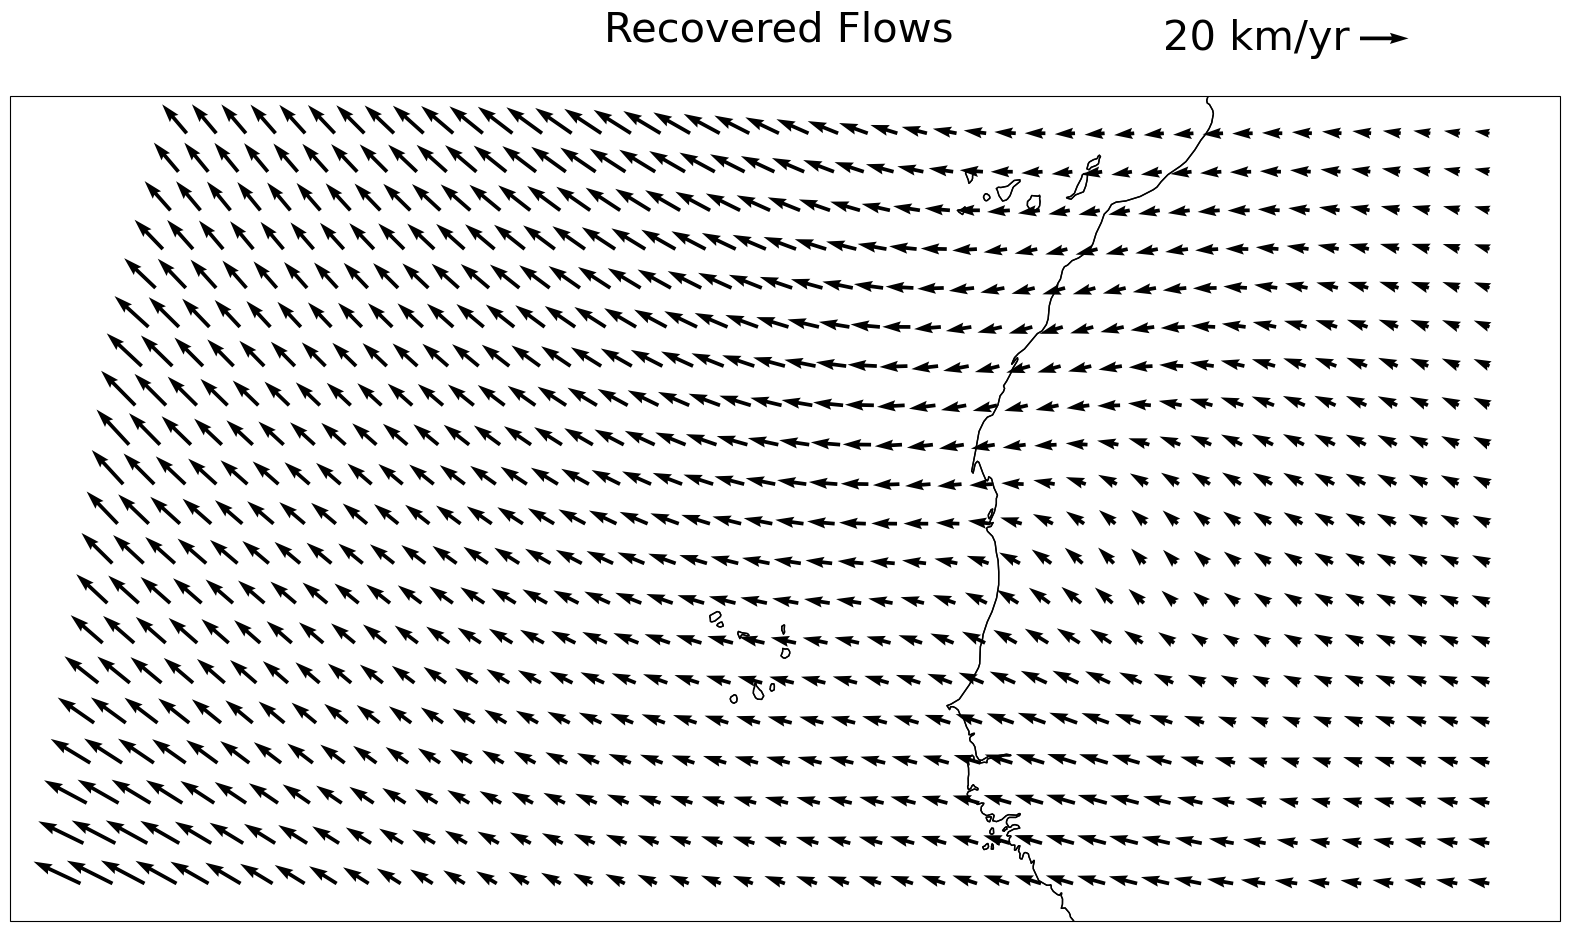

In [16]:
fig = plt.figure(figsize=(20, 20))
proj = ccrs.Mollweide() #ccrs.NearsidePerspective(central_latitude=90., central_longitude = 180)#
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.COASTLINE)
plot2 = ax.quiver(phi_data[5:-5, 5:-5]*180/np.pi, 90-theta_data[5:-5, 5:-5]*180/np.pi, u_phi ,u_theta,color = 'black', transform=ccrs.PlateCarree())
ax.quiverkey(plot2, 0.8, 0.73, 20, label = '20 km/yr', labelpos='W',coordinates='figure',  fontproperties={'size':30})
ax.set_title("Recovered Flows \n", size = '30')


Text(0.5, 1.05, 'Input and Output SV, TG Assumption')

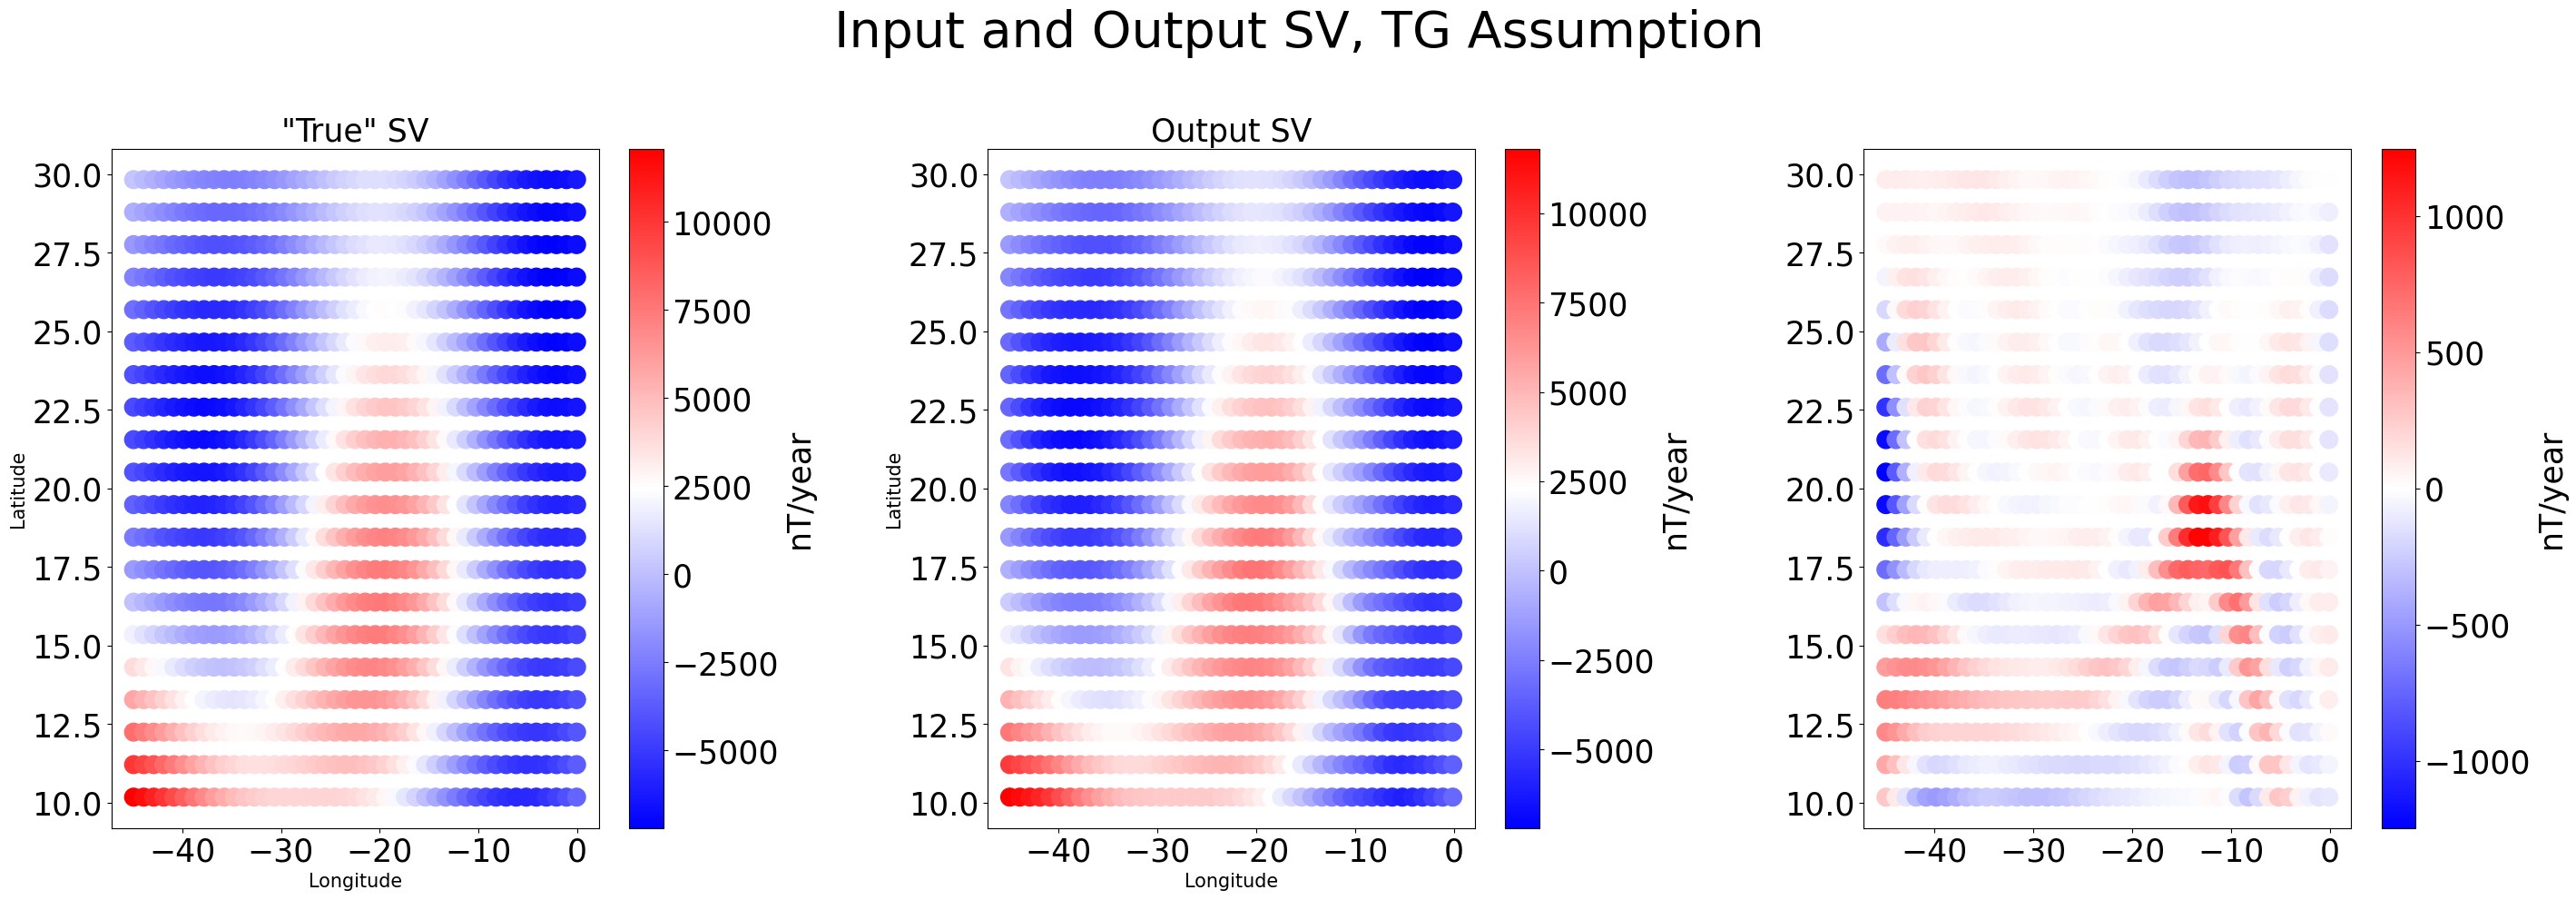

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
plot1 = ax1.scatter(phi_data[5:-5, 5:-5]*180/np.pi, 90-theta_data[5:-5, 5:-5]*180/np.pi, c=sv_nt,cmap = 'bwr', s=200)
plot3 =ax2.scatter(phi_data[5:-5, 5:-5]*180/np.pi, 90-theta_data[5:-5, 5:-5]*180/np.pi, c=sv_pred,cmap = 'bwr', s=200)
plot4 =ax3.scatter(phi_data[5:-5, 5:-5]*180/np.pi, 90-theta_data[5:-5, 5:-5]*180/np.pi, c=res,cmap = 'bwr', vmin = -np.abs(res).max(), vmax = np.abs(res).max(), s=200)
plt.colorbar(plot1, ax = ax1, label = 'nT/year')
plt.colorbar(plot3, ax = ax2, label = 'nT/year')
plt.colorbar(plot4, ax = ax3, label = 'nT/year')
plt.tight_layout(pad=3)
ax1.set_title('"True" SV', fontsize = 25)
ax1.set_xlabel('Longitude', fontsize = 15)
ax1.set_ylabel('Latitude', fontsize = 15)

ax2.set_title('Output SV', fontsize = 25)
ax2.set_xlabel('Longitude', fontsize = 15)
ax2.set_ylabel('Latitude', fontsize = 15)

ax4.set_title('Residual SV, RMSE {0:.0f} nT/year.'.format(rmse_sv), fontsize = 25)
ax4.set_xlabel('Longitude', fontsize = 15)
ax4.set_ylabel('Latitude', fontsize = 15)
plt.suptitle("Input and Output SV, TG Assumption", fontsize = 40, y = 1.05)